# Load Data

In [2]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # for validation

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=train_transforms)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers) # for validation: sampler = train_sampler
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers) # for validation: sampler = train_sampler
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

0it [00:00, ?it/s]

9920512it [00:02, 3715468.17it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 275044.03it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1883887.46it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 107342.32it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Visualize a batch

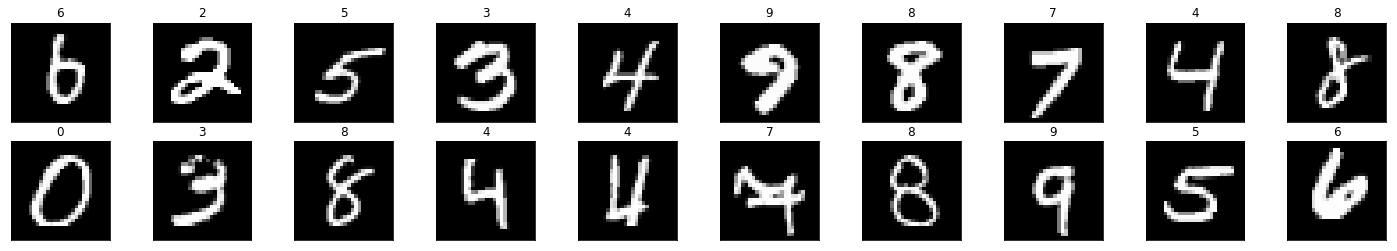

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

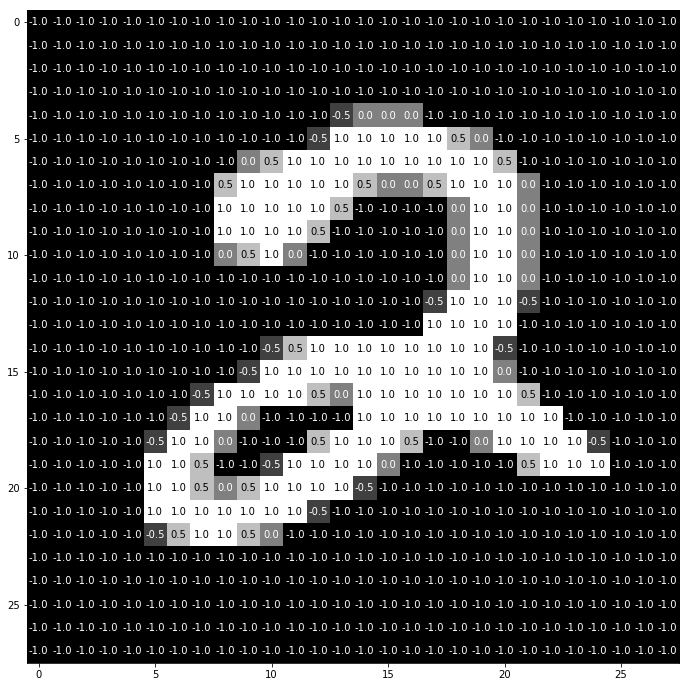

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define Classifier

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
       # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        # convolutional layer (sees 14x14x4 tensor after MaxPool)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (7 * 7 * 16)
        self.fc1 = nn.Linear(7 * 7 * 16, 512)
        # linear layer (512 -> 10)
        self.fc2 = nn.Linear(512, 10)
        # dropout layer (p=0.20)
        self.dropout = nn.Dropout(0.20)
        
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 7 * 7 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        # LogSoftMax
        return F.log_softmax(x, dim=1)
        
# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [33]:
from torch import optim

# Loss Function and Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [34]:
# move tensors to GPU if CUDA is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

In [35]:
epochs = 20
steps = 0


train_losses, test_losses = [], []
for e in range(epochs):
    
    train_loss = 0.0
    vaild_loss = 0.0
    
    model.train()
    
    for images, labels in train_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, label)
            # update average validation loss 
            valid_loss += loss.item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss        
        


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
x = range(epoch)
plt.plot(x, train_losses, label = "Train losses")
plt.plot(x, test_losses, label = "Test losses")
plt.title("Traning losses vs Test losses")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend()
plt.show()

In [ ]:
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
